# News Vendor

## Pre-requisites 

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [1]:
import sagemaker
import boto3
import sys
import os

from sagemaker.rl import RLEstimator

sys.path.append("common")
from misc import get_execution_role

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata.

In [2]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-west-2-975155340573/


### Define Variables 

We define variables such as the job prefix for the training jobs *and the image path for the container (only when this is BYOC).*

In [19]:
# create a descriptive job name 
job_name_prefix = 'news-vendor-ppo-lead-time-2'

### Configure where training happens
You can train your RL training jobs using the SageMaker notebook instance or local notebook instance. In both of these scenarios, you can run the following in either local or SageMaker modes. The local mode uses the SageMaker Python SDK to run your code in a local container before deploying to SageMaker. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set `local_mode = True`. When setting `local_mode = False`, you can choose the instance type from avaialable [ml instances](https://aws.amazon.com/sagemaker/pricing/instance-types/)

In [20]:
local_mode = False

if local_mode:
    instance_type = 'local'
else:
    # If on SageMaker, pick the instance type
    instance_type = "ml.m5.large"

### Create an IAM role
Either get the execution role when running from a SageMaker notebook instance `role = sagemaker.get_execution_role()` or, when running from local notebook instance, use utils method `role = get_execution_role()` to create an execution role.

In [21]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::975155340573:role/service-role/AmazonSageMaker-ExecutionRole-20190502T151333


### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from you local machine, please make sure that you have docker and docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script to install dependenceis.

Note, you can only run a single local notebook at one time.

In [22]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

### Define the Sagemaker-RL docker image for Ray

We will use the `TensorFlow Ray` for this project. For a list of available RL images see https://github.com/aws/sagemaker-rl-container 

In [23]:
cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
aws_region = boto3.Session().region_name
custom_image_name = "520713654638.dkr.ecr.{}.amazonaws.com/sagemaker-rl-tensorflow:ray0.6.5-{}-py3".format(aws_region, cpu_or_gpu)
print("Using ECR image %s" % custom_image_name)

Using ECR image 520713654638.dkr.ecr.us-west-2.amazonaws.com/sagemaker-rl-tensorflow:ray0.6.5-cpu-py3


## Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The [RLEstimator](https://sagemaker.readthedocs.io/en/stable/sagemaker.rl.html) is used for training RL jobs. 

1. Specify the source directory where the gym environment and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. The RLCOACH_PRESET or the RLRAY_PRESET can be used to specify the RL agent algorithm you want to use. 
6. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks.

### Define Metric
A list of dictionaries that defines the metric(s) used to evaluate the training jobs. Each dictionary contains two keys: ‘Name’ for the name of the metric, and ‘Regex’ for the regular expression used to extract the metric from the logs.

In [24]:
metric_definitions = [{'Name': 'episode_reward_mean',
  'Regex': 'episode_reward_mean: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_reward_max',
  'Regex': 'episode_reward_max: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_len_mean',
  'Regex': 'episode_len_mean: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'entropy',
  'Regex': 'entropy: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_reward_min',
  'Regex': 'episode_reward_min: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'vf_loss',
  'Regex': 'vf_loss: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'policy_loss',
  'Regex': 'policy_loss: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},                                            
]

### Define Estimator
This Estimator executes an RLEstimator script in a managed Reinforcement Learning (RL) execution environment within a SageMaker Training Job. The managed RL environment is an Amazon-built Docker container that executes functions defined in the supplied entry_point Python script.

In [25]:
train_entry_point = "train_news_vendor_ppo.py"
train_job_max_duration_in_seconds = 3600 * 24 * 2

estimator = RLEstimator(entry_point=train_entry_point,
                        source_dir="src",
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        train_max_run=train_job_max_duration_in_seconds,
                        hyperparameters={}
                       )

In [30]:
estimator.fit(wait=local_mode)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

Training job: news-vendor-ddpg-lead-time-2-2019-07-10-08-21-52-165


### Visualization

RL training can take a long time.  So while it's running there are a variety of ways we can track progress of the running training job.  Some intermediate output gets saved to S3 during training, so we'll set up to capture that.

In [31]:
s3_url = "s3://{}/{}".format(s3_bucket,job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
intermediate_url = "s3://{}/{}training/".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Intermediate folder path: {}".format(intermediate_url))

S3 job path: s3://sagemaker-us-west-2-975155340573/news-vendor-ddpg-lead-time-2-2019-07-10-08-21-52-165
Intermediate folder path: s3://sagemaker-us-west-2-975155340573/news-vendor-ddpg-lead-time-2-2019-07-10-08-21-52-165/output/intermediate/training/


In [32]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

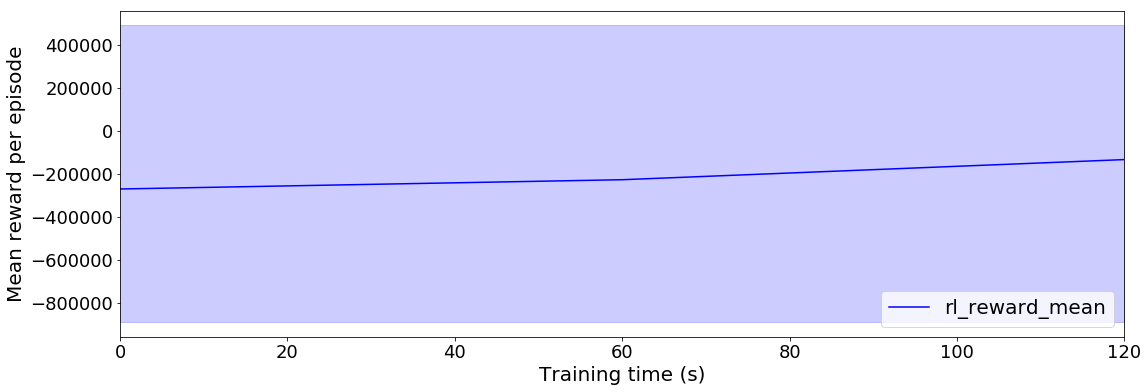

In [33]:
if not local_mode:
    df = TrainingJobAnalytics(job_name, ['episode_reward_mean']).dataframe()
    df_min = TrainingJobAnalytics(job_name, ['episode_reward_min']).dataframe()
    df_max = TrainingJobAnalytics(job_name, ['episode_reward_max']).dataframe()
    df['rl_reward_mean'] = df['value']
    df['rl_reward_min'] = df_min['value']
    df['rl_reward_max'] = df_max['value']
    num_metrics = len(df)
    
    if num_metrics == 0:
        print("No algorithm metrics found in CloudWatch")
    else:
        plt = df.plot(x='timestamp', y=['rl_reward_mean'], figsize=(18,6), fontsize=18, legend=True, style='-', color=['b','r','g'])
        plt.fill_between(df.timestamp, df.rl_reward_min, df.rl_reward_max, color='b', alpha=0.2)
        plt.set_ylabel('Mean reward per episode', fontsize=20)
        plt.set_xlabel('Training time (s)', fontsize=20)
        plt.legend(loc=4, prop={'size': 20})
else:
    print("Can't plot metrics in local mode.")